In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np
from tqdm.notebook import tqdm  # Use notebook-friendly tqdm
import matplotlib.pyplot as plt
from argparse import Namespace
import sys

sys.path.append("..")
sys.path.append("data")
# Import your project modules (adjust the import paths as needed)
from main_transductive import pretrain
from src.utils import set_random_seed, create_optimizer, WBLogger
from src.datasets.data_util import load_dataset, load_processed_graph
from src.models import build_model, PreModel
from src.evaluation import node_classification_evaluation
from src.utils import build_args, load_best_configs  # if needed

In [116]:
# ----------------------
# Config settings
# ----------------------
# Choose device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set seed for reproducibility
seed = 0
set_random_seed(seed)

In [117]:
# Define training hyperparameters
dataset_name = "CPDB_cdgps"
max_epoch = 100  # Total training epochs
max_epoch_f = 200
num_hidden = 64
num_layers = 3
encoder_type = "rgcn"
decoder_type = "rgcn"
replace_rate = 0.05
num_edge_types = 6
in_drop = 0.2
attn_drop = 0.1
mask_rate = 0.5
drop_edge_rate = 0.0
alpha_l = 3
num_heads = 4
activation = "prelu"
optimizer = "adam"
loss_fn = "sce"
lr = 0.01
weight_decay = 1e-3
lr_f = 0.005
weight_decay_f = 1e-4
linear_prob = False
load_model = False  # Set True to load a checkpoint
save_model = True  # Set True to save trained model
logs = True  # Set True to use WBLogger
use_scheduler = True  # Set True to use a learning rate scheduler
weight_decomposition = {"type": "basis", "num_bases": 2}
vertical_stacking = True

In [118]:
# ----------------------
# Create a Namespace for Args
# ----------------------

args = Namespace(
    device=device,
    seeds=[seed],
    dataset=dataset_name,
    max_epoch=max_epoch,
    max_epoch_f=max_epoch_f,
    num_hidden=num_hidden,
    num_layers=num_layers,
    encoder=encoder_type,
    decoder=decoder_type,
    activation=activation,
    in_drop=in_drop,
    attn_drop=attn_drop,
    mask_rate=mask_rate,
    drop_edge_rate=drop_edge_rate,
    alpha_l=alpha_l,
    num_heads=num_heads,
    weight_decomposition=weight_decomposition,
    vertical_stacking=vertical_stacking,
    replace_rate=replace_rate,
    num_edge_types=num_edge_types,
    optimizer=optimizer,
    loss_fn=loss_fn,
    lr=lr,
    weight_decay=weight_decay,
    lr_f=lr_f,
    weight_decay_f=weight_decay_f,
    linear_prob=linear_prob,
    load_model=load_model,
    save_model=save_model,
    logging=logs,
    scheduler=use_scheduler,
    num_features=6,
    num_out_heads=1,
    residual=False,
    norm=None,
    negative_slope=0.2,
    concat_hidden=False,
    # return_hidden = False,
)

In [119]:
# ----------------------
# Load Dataset and Build Model
# ----------------------
# graph, (num_features, num_classes) = load_dataset(dataset_name)
graph = load_processed_graph(
    f"../data/components/multidim_graph/6d/{dataset_name}_multiomics.pt"
)
num_features = graph.x.shape[1]
num_classes = graph.y.max().item() + 1

args.num_features = num_features

model = build_model(args)
model.to(device)

PreModel(
  (encoder): RGCN(
    (rgcn_layers): ModuleList(
      (0-2): 3 x RGCNConv(64, 64)
    )
    (activation): PReLU(num_parameters=1)
    (head): Identity()
  )
  (decoder): RGCN(
    (rgcn_layers): ModuleList(
      (0): RGCNConv(64, 64)
    )
    (activation): PReLU(num_parameters=1)
    (head): Identity()
  )
  (encoder_to_decoder): Linear(in_features=64, out_features=64, bias=False)
)

In [120]:
# ----------------------
# Create Optimizer and Scheduler
# ----------------------
optimizer = create_optimizer(optimizer, model, lr, weight_decay)

scheduler = None
if use_scheduler:
    # Example: cosine scheduler (you can adjust the function as needed)
    scheduler_fn = lambda epoch: (1 + np.cos(epoch * np.pi / max_epoch)) * 0.5
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=scheduler_fn)

In [121]:
# ----------------------
# Setup Logger (Optional)
# ----------------------
logger = WBLogger(name="notebook_training") if logs else None

In [122]:
# ----------------------
# Train the Model
# ----------------------
# Here, graph.x is assumed to be your feature matrix.
# If needed, make sure it's on the same device as your model.
model = pretrain(
    model,
    graph,
    graph.x.to(device),
    optimizer,
    max_epoch,
    device,
    scheduler,
    num_classes,
    lr_f,
    weight_decay_f,
    max_epoch_f,
    linear_prob,
    num_edge_types,
    logger,
)

2025-03-21 01:31:34,063 - INFO - start training..
# Epoch 99: train_loss: 0.1408: 100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


In [123]:
model = model.cpu()  # move model to cpu for eval

# Optionally save or load the model checkpoint
if save_model:
    torch.save(model.state_dict(), "../checkpoints/emb_extraction_model.pt")
if load_model:
    model.load_state_dict(torch.load("checkpoint.pt"))

In [124]:
# ----------------------
# Evaluate the Model
# ----------------------
model.to(device)
model.eval()

(
    (test_acc, estp_test_acc),
    (test_auc, estp_test_auc),
    (test_aupr, estp_test_aupr),
    (test_precision, estp_test_precision),
    (test_recall, estp_test_recall),
    (test_f1, estp_f1),
) = node_classification_evaluation(
    model,
    graph,
    graph.x,
    num_classes,
    lr_f,
    weight_decay_f,
    max_epoch_f,
    device,
    linear_prob=False,
)

num parameters for finetuning: 66281
Number of positive labels: tensor(196.)
Number of negative labels: tensor(195.)


# Epoch: 199, train_loss: 0.0738, val_loss: 0.8964, val_acc:0.8877551020408163, val_aupr: 0.9635, test_loss: 1.2509, test_acc: 0.9106,test_auc: 0.9322, test_aupr: 0.9200: 100%|██████████| 200/200 [01:06<00:00,  2.99it/s]

--- TestAcc: 0.9106, early-stopping-TestAcc: 0.9024, Best ValAcc: 0.8980 in epoch 164 --- 
--- TestAUPR: 0.9200, early-stopping-TestAUPR: 0.9219, Best ValAUPR: 0.9648 in epoch 197 --- 


In [125]:
logger.note(
    {
        "test_accuracy": test_acc,
        "test_estp_accuracy": estp_test_acc,
        "test_auc": test_auc,
        "test_estp_auc": estp_test_auc,
        "test_aupr": test_aupr,
        "test_estp_aupr": estp_test_aupr,
        "test_precision": test_precision,
        "test_estp_precision": estp_test_precision,
        "test_recall": test_recall,
        "test_estp_recall": estp_test_recall,
        "test_f1": test_f1,
        "test_estp_f1": estp_f1,
    },
    step=max_epoch,
)

In [126]:
# Assume you have already loaded your trained model, graph, and features (x)
# Set your model to evaluation mode
model.eval()

# Extract embeddings and predictions from the model.

with torch.no_grad():
    rep, hid_list = model.embed(graph, graph.x, num_edge_types)
    encoder = model.encoder
    pred = encoder(graph, graph.x, graph.num_edge_types)

embeddings = hid_list[-1]

embeddings.shape
# Convert embeddings to a numpy array if they are a torch.Tensor
# embeddings_np = np.array(embeddings)

# print("Embeddings shape:", embeddings_np.shape)

torch.Size([13627, 64])

In [127]:
pred_labels_scores = torch.sigmoid(pred)
pred_labels = (pred_labels_scores >= 0.5).int()

In [128]:
df = pd.DataFrame(columns=["Gene", "Label", "Pred", "Score"])
df["Gene"] = graph.name
df["Label"] = graph.y
df["Pred"] = pred_labels
df["Score"] = pred_labels_scores.cpu().numpy()

In [129]:
df.to_csv(f"../results/emb_extraction_model_pred.csv", index=False)

In [130]:
df[df["Pred"] == df["Label"]]

,Gene,Label,Pred,Score
0,STIM1,0.0,0,0.011550
1,TRPC1,0.0,0,0.057710
3,ATP2B4,0.0,0,0.416965
5,KCNJ11,1.0,1,1.000000
6,HADHA,0.0,0,0.012904
...,...,...,...,...
13622,GPR153,0.0,0,0.026982
13623,HDC,0.0,0,0.006820
13624,CSMD1,0.0,0,0.421210
13625,BHLHE22,0.0,0,0.029990


In [131]:
# Retrieve the class labels from graph.y and convert to numpy array
labels = graph.y.cpu().numpy() if hasattr(graph, "y") else None
labels = labels.squeeze()

In [132]:
labels

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [133]:
# Apply t-SNE to reduce embeddings to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

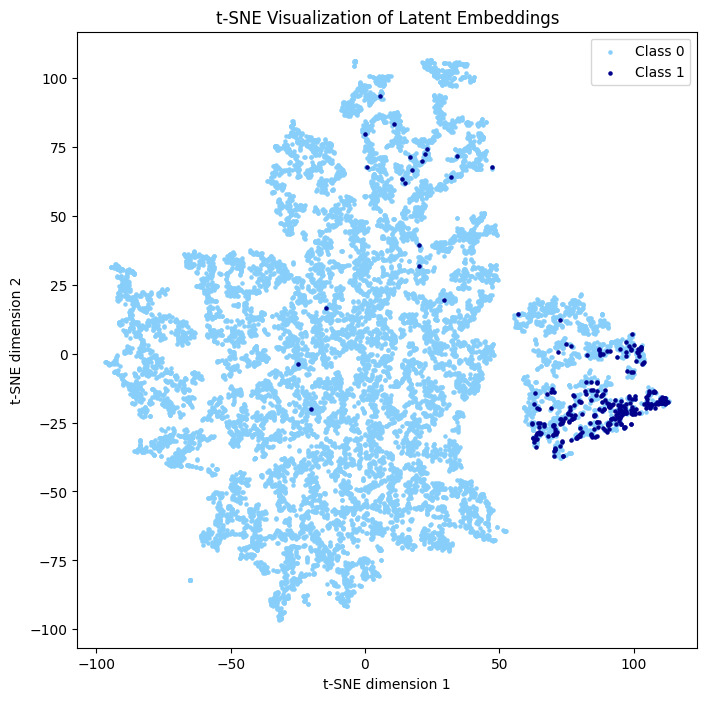

In [141]:
# Create masks for binary classes
mask0 = labels == 0
mask1 = labels == 1

plt.figure(figsize=(8, 8))
plt.scatter(
    embeddings_2d[mask0, 0],
    embeddings_2d[mask0, 1],
    label="Class 0",
    s=5,
    color="lightskyblue",
)
plt.scatter(
    embeddings_2d[mask1, 0],
    embeddings_2d[mask1, 1],
    label="Class 1",
    s=5,
    color="darkblue",
)

plt.title("t-SNE Visualization of Latent Embeddings")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend()
plt.savefig("../figures/emb_extraction_model_latent_space_true_labels.png", dpi=300)
plt.show()

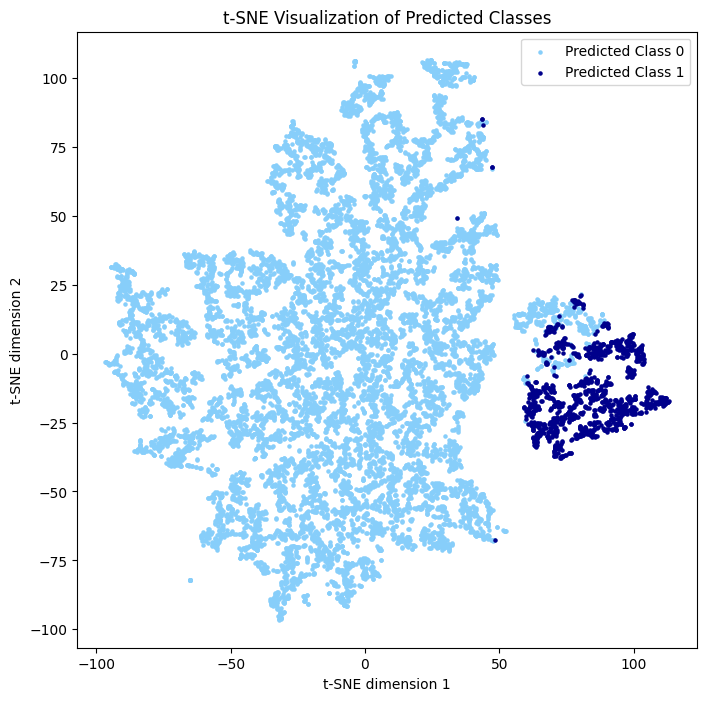

In [144]:
# Ensure predicted labels are 1D
pred_labels_np = pred_labels.cpu().numpy().squeeze()

# Create boolean masks for the two classes
mask0 = pred_labels_np == 0
mask1 = pred_labels_np == 1

plt.figure(figsize=(8, 8))

plt.scatter(
    embeddings_2d[mask0, 0],
    embeddings_2d[mask0, 1],
    label="Predicted Class 0",
    s=5,
    color="lightskyblue",
)
plt.scatter(
    embeddings_2d[mask1, 0],
    embeddings_2d[mask1, 1],
    label="Predicted Class 1",
    s=5,
    color="darkblue",
)
plt.title("t-SNE Visualization of Predicted Classes")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend()
plt.savefig("../figures/emb_extraction_model_latent_space_pred_labels.png", dpi=300)
plt.show()

In [96]:
print("True labels (first 20):", labels[:20])
print("Predictions (first 20):", pred[:20])

True labels (first 20): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Predictions (first 20): tensor([[ 0.0150],
        [ 0.0286],
        [-0.0719],
        [ 0.0196],
        [-0.1021],
        [ 0.0282],
        [ 0.0377],
        [ 0.0188],
        [ 0.0208],
        [ 0.0425],
        [-0.0267],
        [ 0.0411],
        [ 0.0441],
        [ 0.0358],
        [ 0.0282],
        [ 0.0294],
        [ 0.0313],
        [ 0.0092],
        [-0.0416],
        [ 0.0420]])


In [97]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(labels, pred_labels))

[[  676 12645]
 [  125   181]]


In [98]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{np.float32(0.0): np.int64(13321), np.float32(1.0): np.int64(306)}


In [99]:
unique, counts = np.unique(pred_labels, return_counts=True)
print(dict(zip(unique, counts)))

{np.int32(0): np.int64(801), np.int32(1): np.int64(12826)}
